In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera

from sklearn.metrics import mean_absolute_error, mean_squared_error

import pmdarima as pm
import warnings
warnings.filterwarnings('ignore')


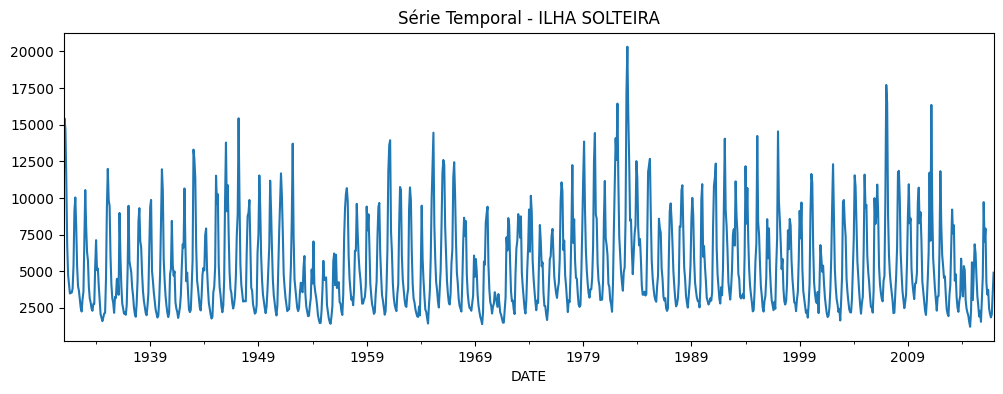

In [2]:
# === CARREGAMENTO E PRÉ-PROCESSAMENTO ===

#Arquivo Excel

df = pd.read_excel('C:\\Users\\Evert\\Documents\\ILHA_SOLTEIRA_FORMATADO.xlsx')

#Formatação da coluna de datas
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)
df = df.asfreq('MS') #Frequência mensal

#Visualização inicial
df['VALUE'].plot(figsize=(12,4), title='Série Temporal - ILHA SOLTEIRA')
plt.show()


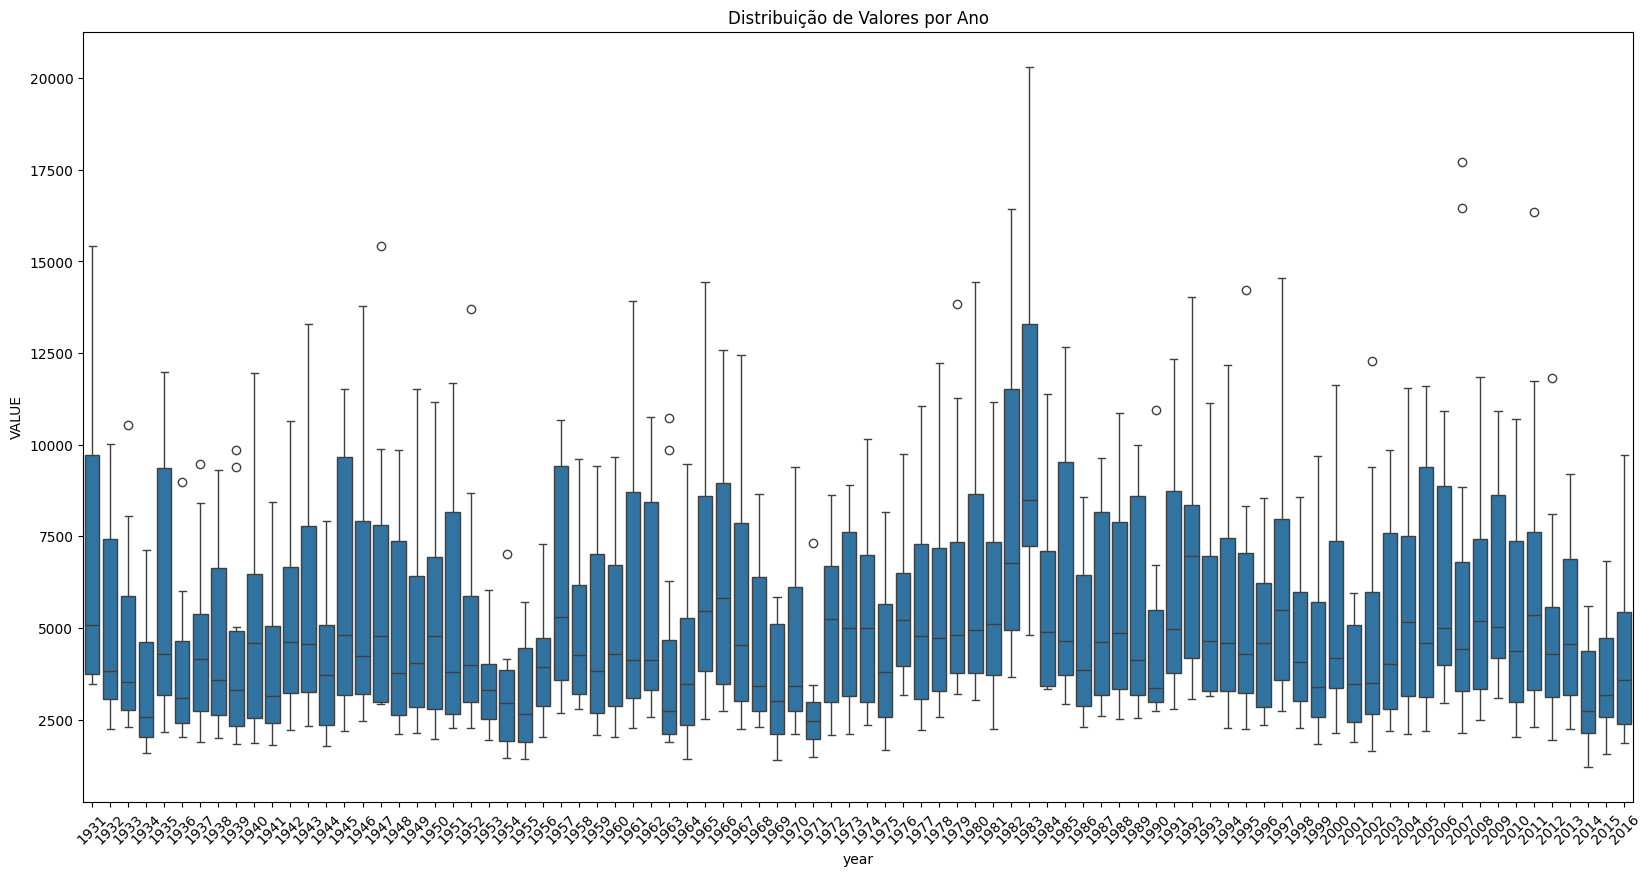

ADF Statistic: -3.6857
p-value: 0.0043
Critical Values: {'1%': -3.4368475364676088, '5%': -2.86440871710881, '10%': -2.568297437011397}


In [3]:
# === ANÁLISE EXPLORATÓRIA E ESTACIONARIEDADE ===

# Boxplot por ano
df_plot = df.copy()
df_plot['year'] = df_plot.index.year
plt.figure(figsize=(20,10))
sns.boxplot(x='year', y='VALUE', data=df_plot)
plt.title('Distribuição de Valores por Ano')
plt.xticks(rotation=45)
plt.show()

# Teste ADF
result = adfuller(df['VALUE'].dropna())
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
print('Critical Values:', result[4])

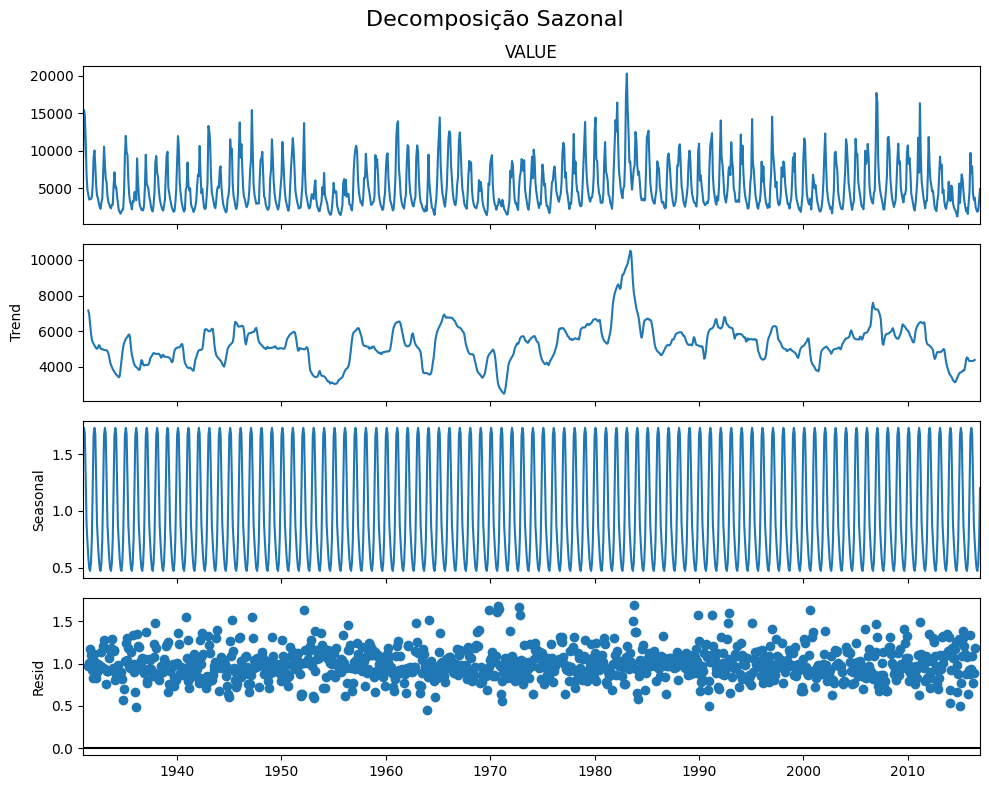

In [4]:
# === DECOMPOSIÇÃO SAZONAL ===

decomp = seasonal_decompose(df['VALUE'], model='multiplicative', period=12)
fig = decomp.plot()
fig.set_size_inches(10, 8)

plt.suptitle("Decomposição Sazonal", fontsize=16)
plt.tight_layout()
plt.show()

In [5]:
"""DIVISÃO TREINO/TESTE"""

#Calibração: até 2010
#Avaliação: 2011 em diante
df_train = df[:'2010']
df_test = df['2011':]

In [7]:
# === FUNÇÕES AUXILIARES ===

# EPMA
def epma(real, previsao):
    return np.mean(np.abs((real - previsao) / real)) * 100

# Rolling Forecast - ARMA, ARIMA, SARIMA
def rolling_forecast(train, test, order=(0,0,0), seasonal_order=(0,0,0,0), seasonal=False):
    history = train.copy()
    preds = []

    for t in range(len(test)):
        if seasonal:
            model = SARIMAX(history,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
        else:
            model = ARIMA(history, order=order)
        
        fit = model.fit()
        yhat = fit.forecast()[0]
        preds.append(yhat)

        # Alimenta o modelo com o valor REAL, não a previsão
        history = pd.concat([history, pd.Series([test.iloc[t]], index=[test.index[t]])])

    return pd.Series(preds, index=test.index)


def rolling_forecast_auto_arima(train, test):
    # Passo 1: Encontrar os melhores parâmetros uma única vez
    best_model = pm.auto_arima(train,
                             seasonal=False,
                             suppress_warnings=True,
                             error_action='ignore',
                             stepwise=True)
    order = best_model.order

    #Passo 2: Usar rolling forecast com modelo fixo
    history = train.copy()
    preds = []

    for t in range(len(test)):
        # Usa a ordem já determinada, apenas ajustando os coeficientes
        model = ARIMA(history, order=order).fit()
        yhat = model.forecast()[0]
        preds.append(yhat)
        history = pd.concat([history, pd.Series([test.iloc[t]], index=[test.index[t]])])

    return pd.Series(preds, index=test.index)


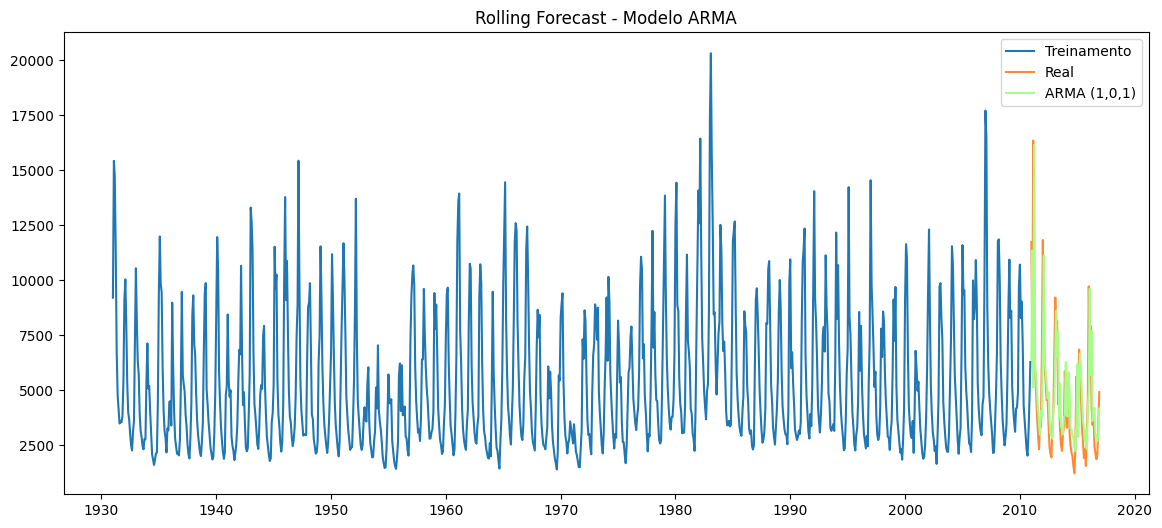

In [8]:
# === MODELAGEM E PREVISÃO ===

# ARMA (p=1, q=1)
fc_arma = rolling_forecast(df_train['VALUE'], df_test['VALUE'], order=(1,0,1))
plt.figure(figsize=(14,6))
plt.plot(df_train['VALUE'], label='Treinamento')
plt.plot(df_test['VALUE'], label='Real', color='#FF8A33')
plt.plot(fc_arma, label='ARMA (1,0,1)', color= '#A7FC8A')
plt.title('Rolling Forecast - Modelo ARMA')
plt.legend()
plt.show()

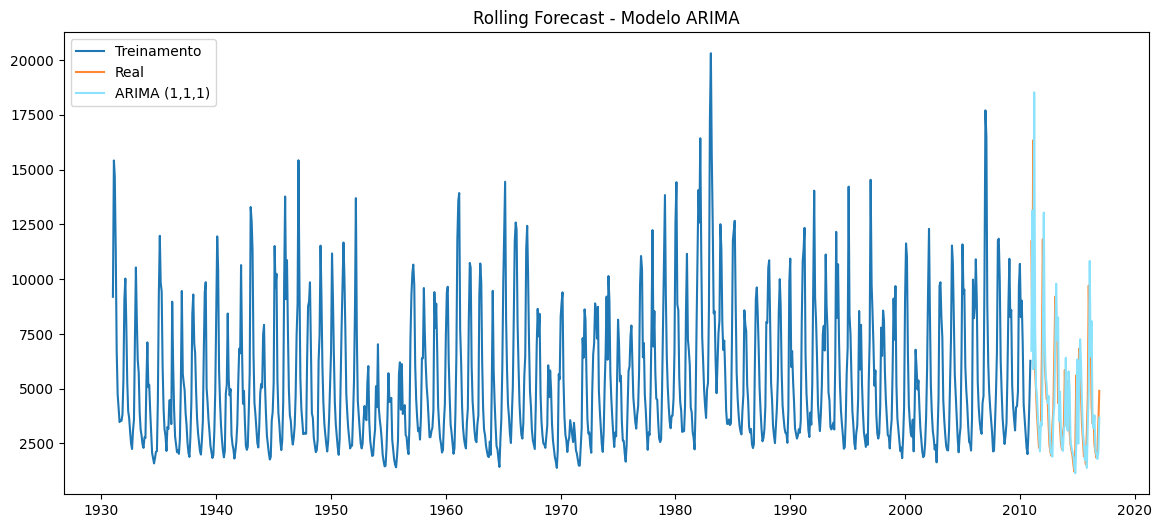

In [9]:
# ARIMA (p=1, d=1, q=1)
fc_arima = rolling_forecast(df_train['VALUE'], df_test['VALUE'], order=(1,1,1))
plt.figure(figsize=(14,6))
plt.plot(df_train['VALUE'], label='Treinamento')
plt.plot(df_test['VALUE'], label='Real', color='#FF8A33')
plt.plot(fc_arima, label='ARIMA (1,1,1)', color= '#8AE2FC')
plt.title('Rolling Forecast - Modelo ARIMA')
plt.legend()
plt.show()

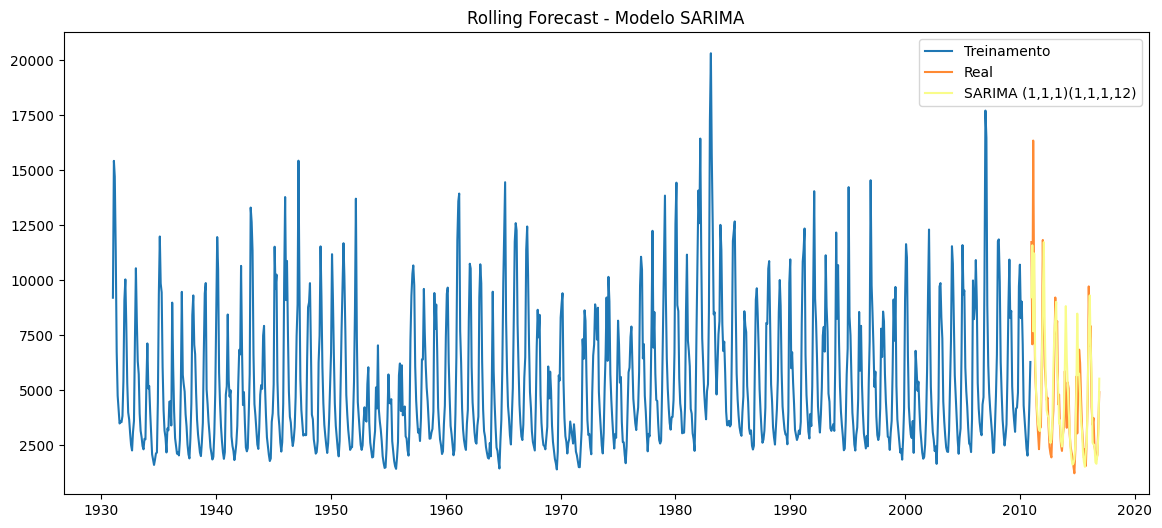

In [10]:
# SARIMA manual (1,1,1)(1,1,1,12)
fc_sarima = rolling_forecast(df_train['VALUE'], df_test['VALUE'],
                              order=(1,1,1), seasonal_order=(1,1,1,12), seasonal=True)
plt.figure(figsize=(14,6))
plt.plot(df_train['VALUE'], label='Treinamento')
plt.plot(df_test['VALUE'], label='Real', color='#FF8A33')
plt.plot(fc_sarima, label='SARIMA (1,1,1)(1,1,1,12)', color= '#F9FC8A')
plt.title('Rolling Forecast - Modelo SARIMA')
plt.legend()
plt.show()

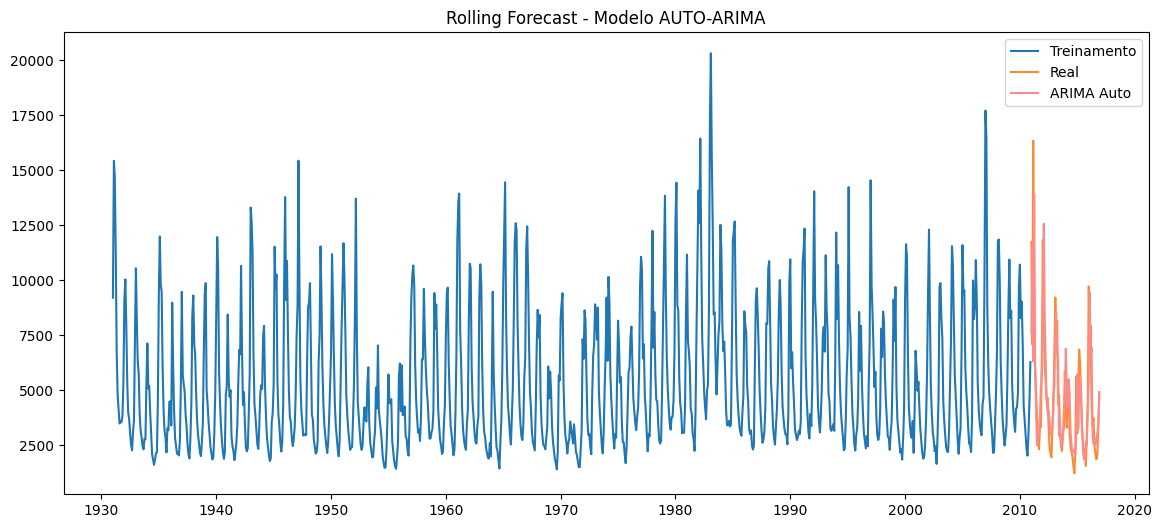

In [11]:
# ARIMA automático (não sazonal)
fc_arima_auto = rolling_forecast_auto_arima(df_train['VALUE'], df_test['VALUE'])
plt.figure(figsize=(14,6))
plt.plot(df_train['VALUE'], label='Treinamento')
plt.plot(df_test['VALUE'], label='Real', color='#FF8A33')
plt.plot(fc_arima_auto, label='ARIMA Auto', color= '#FC8C8A' )
plt.title('Rolling Forecast - Modelo AUTO-ARIMA')
plt.legend()
plt.show()

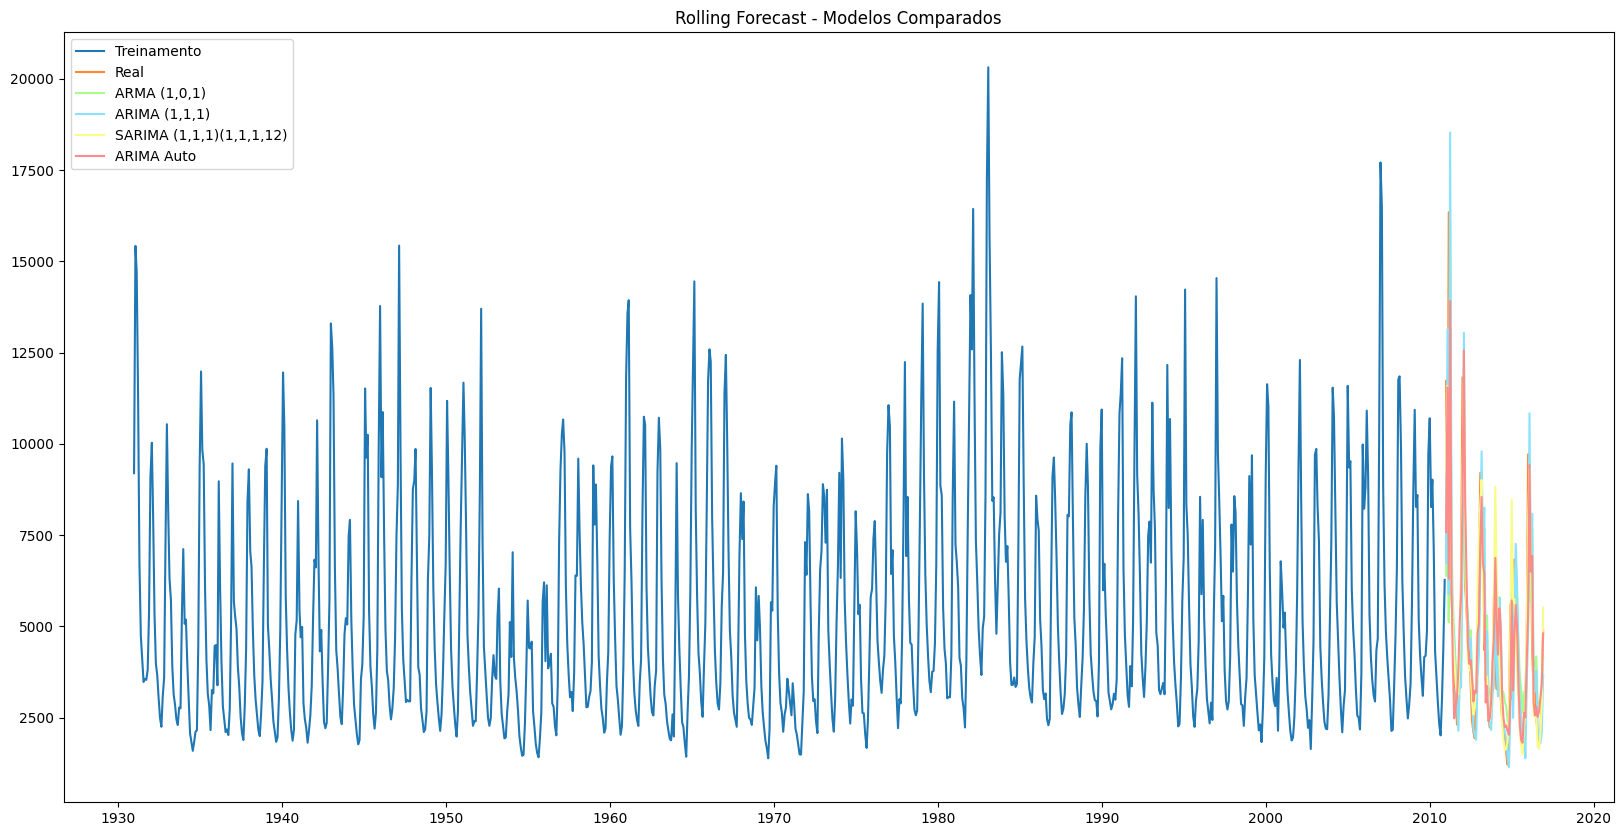

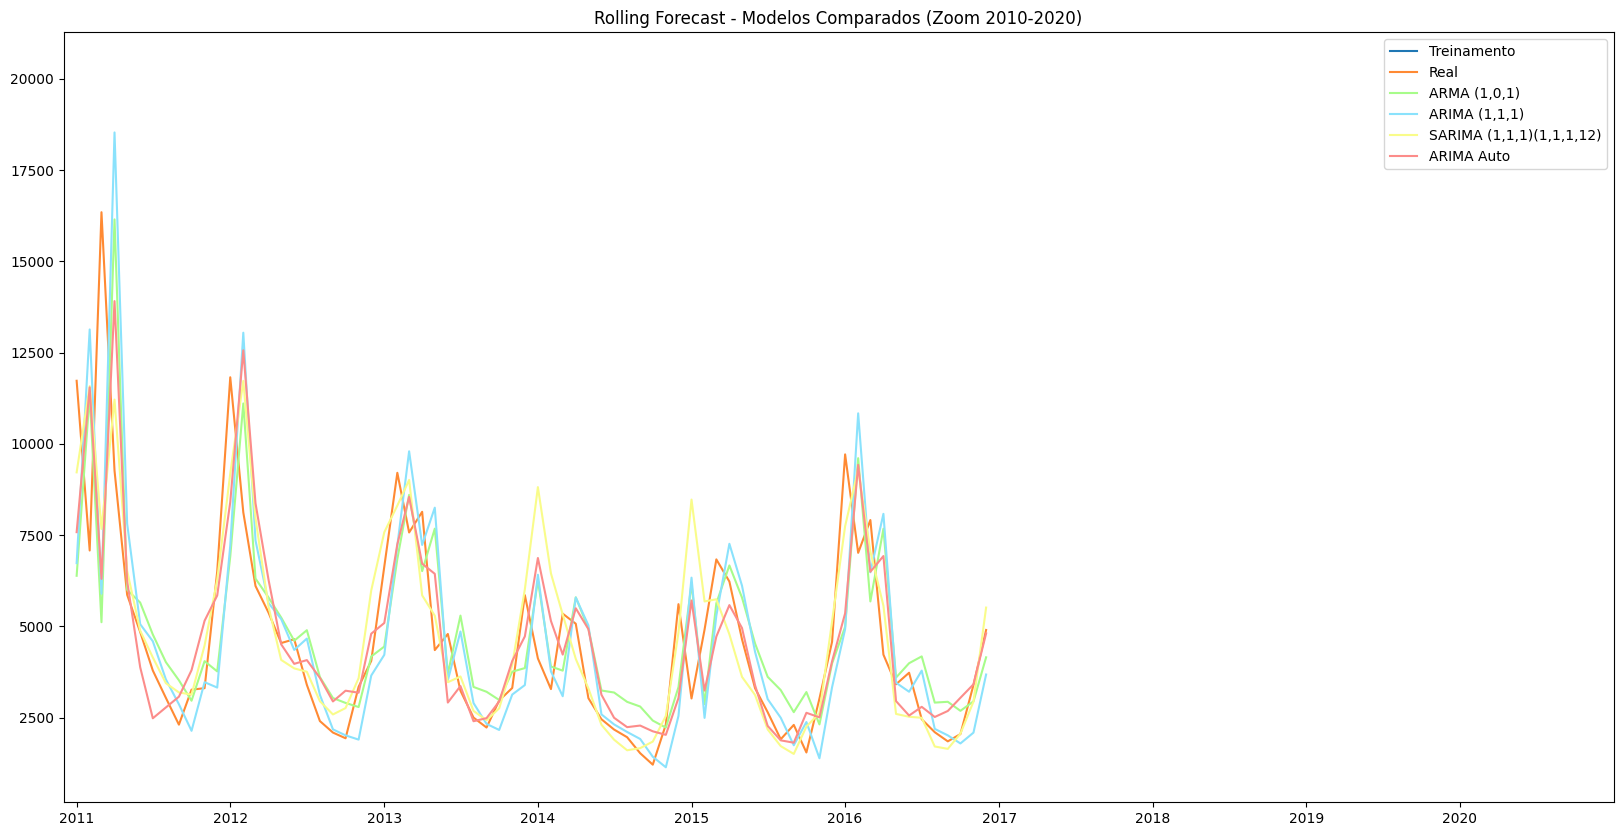

In [12]:
# === PLOTAGEM DAS PREVISÕES ===

plt.figure(figsize=(20, 10))
plt.plot(df_train['VALUE'], label='Treinamento')
plt.plot(df_test['VALUE'], label='Real', color='#FF8A33')
plt.plot(fc_arma, label='ARMA (1,0,1)', color= '#A7FC8A')
plt.plot(fc_arima, label='ARIMA (1,1,1)', color= '#8AE2FC')
plt.plot(fc_sarima, label='SARIMA (1,1,1)(1,1,1,12)', color= '#F9FC8A')
plt.plot(fc_arima_auto, label='ARIMA Auto', color= '#FC8C8A')
plt.title('Rolling Forecast - Modelos Comparados')
plt.legend()
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(df_train['VALUE'], label='Treinamento')
plt.plot(df_test['VALUE'], label='Real', color='#FF8A33')
plt.plot(fc_arma, label='ARMA (1,0,1)', color= '#A7FC8A')
plt.plot(fc_arima, label='ARIMA (1,1,1)', color= '#8AE2FC')
plt.plot(fc_sarima, label='SARIMA (1,1,1)(1,1,1,12)', color= '#F9FC8A')
plt.plot(fc_arima_auto, label='ARIMA Auto', color= '#FC8C8A')
plt.title('Rolling Forecast - Modelos Comparados (Zoom 2010-2020)')
plt.xlim(['2010-12-01', '2020-12-31'])
plt.legend()
plt.show()

In [13]:
# === AVALIAÇÃO DOS MODELOS ====

def avaliar_modelos(df_test, fc_arma, fc_arima, fc_sarima, fc_arima_auto):
    fc_persist = df_test.shift(1).dropna()
    epma_persist = epma(df_test[1:], fc_persist[1:])

    epma_arma = epma(df_test, fc_arma)
    epma_arima = epma(df_test, fc_arima)
    epma_sarima = epma(df_test, fc_sarima)
    epma_arima_auto = epma(df_test, fc_arima_auto)

    tabela = pd.DataFrame({
        'Modelo': ['ARMA (1,0,1)', 'ARIMA (1,1,1)', 'SARIMA (1,1,1)(1,1,1,12)', 'ARIMA Auto', 'Persistência'],
        'EPMA (%)': [epma_arma, epma_arima, epma_sarima, epma_arima_auto, epma_persist]
    })

    tabela = tabela.sort_values(by='EPMA (%)').reset_index(drop=True)
    print("\n Tabela Comparativa dos Modelos:\n")
    print(tabela)

    melhor_modelo = tabela.loc[0, 'Modelo']
    print(f"\n Melhor Modelo: {melhor_modelo} com EPMA de {tabela.loc[0, 'EPMA (%)']:.2f}%\n")

    return melhor_modelo, tabela


# Executar avaliação
melhor_modelo, tabela = avaliar_modelos(
    df_test['VALUE'], 
    fc_arma, 
    fc_arima, 
    fc_sarima, 
    fc_arima_auto
)



 Tabela Comparativa dos Modelos:

                     Modelo   EPMA (%)
0  SARIMA (1,1,1)(1,1,1,12)  23.628386
1                ARIMA Auto  28.770129
2             ARIMA (1,1,1)  32.079756
3              Persistência  32.499159
4              ARMA (1,0,1)  36.281849

 Melhor Modelo: SARIMA (1,1,1)(1,1,1,12) com EPMA de 23.63%



SARIMA


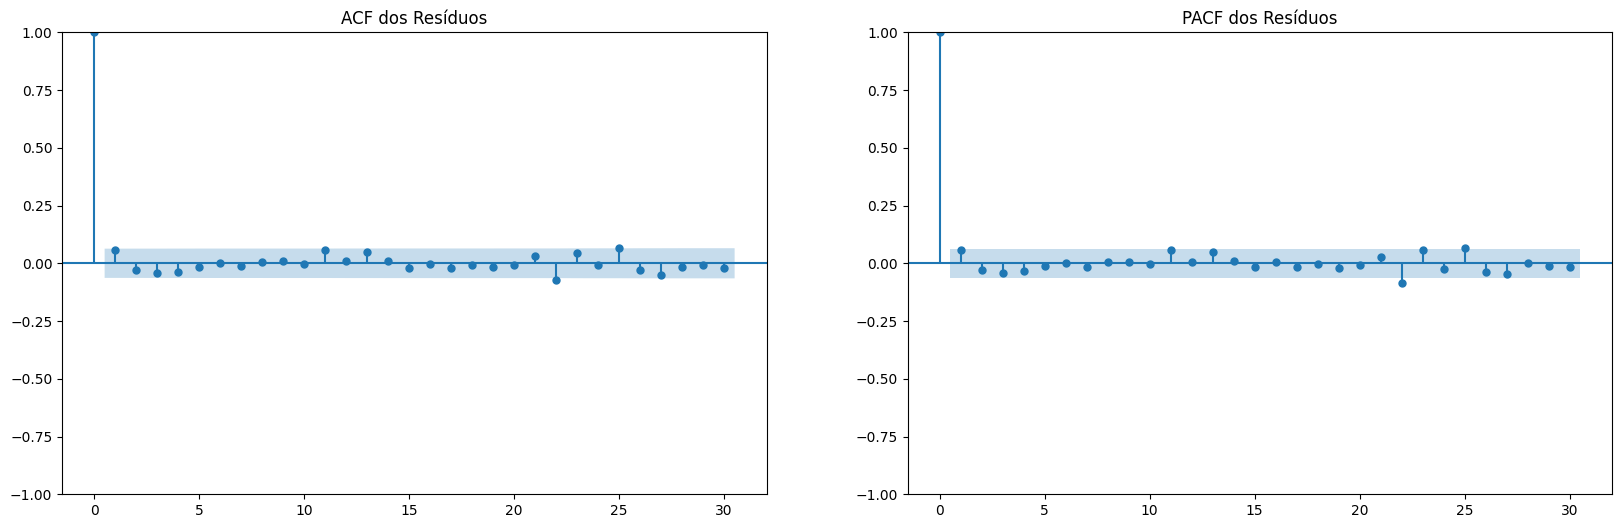

Ljung-Box:
      lb_stat  lb_pvalue
10  7.842288   0.644239
Jarque-Bera: estatística = 886.99, p-valor = 0.0000


In [14]:

# === DIAGNÓSTICO DOS RESÍDUOS ===

if melhor_modelo == 'ARMA (1,0,1)':
    model = ARIMA(df_train['VALUE'], order=(1,0,1))
    fit = model.fit()
    residuos = fit.resid
    print('ARMA')

elif melhor_modelo == 'ARIMA (1,1,1)':
    model = ARIMA(df_train['VALUE'], order=(1,1,1))
    fit = model.fit()
    residuos = fit.resid
    print('ARIMA')

elif melhor_modelo == 'SARIMA (1,1,1)(1,1,1,12)':
    model = SARIMAX(df_train['VALUE'],
                     order=(1,1,1),
                     seasonal_order=(1,1,1,12),
                     enforce_stationarity=False,
                     enforce_invertibility=False)
    fit = model.fit()
    residuos = fit.resid
    print('SARIMA')

elif melhor_modelo == 'ARIMA Auto':
    model = fc_arima_auto = rolling_forecast_auto_arima(df_train['VALUE'], df_test['VALUE'])
    residuos = model.resid()
    print('AUTOARIMA')

elif melhor_modelo == 'Persistência':
    print("Modelo de persistência não possui resíduos para análise estatística.")
    residuos = None

# Se houver resíduos, realizar os diagnósticos
if residuos is not None:
    residuos = pd.Series(residuos).dropna()

    # === Gráficos ACF e PACF ===
    plt.figure(figsize=(20,6))

    plt.subplot(1,2,1)
    plot_acf(residuos, ax=plt.gca())
    plt.title('ACF dos Resíduos')

    plt.subplot(1,2,2)
    plot_pacf(residuos, ax=plt.gca())
    plt.title('PACF dos Resíduos')

    plt.show()

    # === Teste de Ljung-Box ===
    ljung = acorr_ljungbox(residuos, lags=[10], return_df=True)
    print("Ljung-Box:\n", ljung)

    # === Teste de Jarque-Bera ===
    jb_stat, jb_p, _, _ = jarque_bera(residuos)
    print(f"Jarque-Bera: estatística = {jb_stat:.2f}, p-valor = {jb_p:.4f}")

else:
    print("Sem resíduos para análise.")
